In [48]:
import numpy as np
import pandas as pd 
from plotly import graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

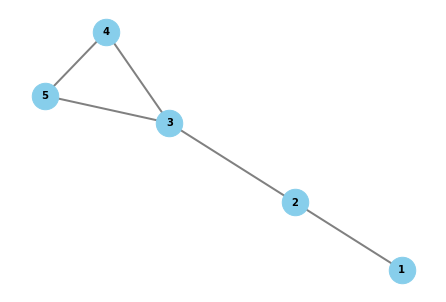

In [6]:
G = nx.Graph()


nodes = [1, 2, 3, 4, 5]
G.add_nodes_from(nodes)


edges = [(1, 2), (2, 3), (3, 4), (3, 5), (4, 5)]
G.add_edges_from(edges)


pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', width=2, edge_color='gray' )


plt.show()


# Question 1A

In [34]:
degrees = Counter([x for tup in edges for x in tup])


fig = go.Figure()
fig.add_trace(go.Bar(x=list(degrees.keys()), y=list(degrees.values())))


fig.update_layout(
    title='Histogram of Degrees',
    xaxis=dict(title='Degrees'),
    yaxis=dict(title='Frequency')
)


fig.show()

# Question 1B

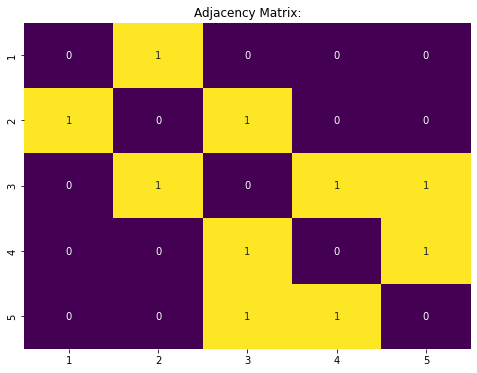

In [65]:
adjacency_matrix = nx.adjacency_matrix(G)

dense_adjacency_matrix = adjacency_matrix.todense()
df = pd.DataFrame(data=dense_adjacency_matrix, columns=nodes, index= nodes)


plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap='viridis', cbar=False, yticklabels=True, annot=True)
plt.title('Adjacency Matrix:')
plt.show()

# Question 1C

In [68]:
for x, y in nx.betweenness_centrality(G).items():
    print(x,":",y)

1 : 0.0
2 : 0.5
3 : 0.6666666666666666
4 : 0.0
5 : 0.0
